In [1]:
import scipy as sp
import pylab as plt
from scipy.integrate import odeint

In [2]:
# full Hodgkin-Huxley model
# membrane capacitance (uF/cm^2)
C_m  =   1.0 
    
#constants for Na
g_Na = 120.0
E_Na =  50.0

#constants for K
g_K  =  36.0
E_K  = -77.0

#constants for leak
g_L  =   0.3
E_L  = -54.387


#time we'll be integrating over. We'll be operating over 450 ms with a step size of 0.01.
t = sp.arange(0.0, 450.0, 0.01)


#functions for rate constants of ion channels
def alpha_m(V):
    return 0.1*(V+40.0)/(1.0 - sp.exp(-(V+40.0) / 10.0))

def beta_m(V):
    return 4.0*sp.exp(-(V+65.0) / 18.0)

def alpha_h(V):
    return 0.07*sp.exp(-(V+65.0) / 20.0)

def beta_h(V):
    return 1.0/(1.0 + sp.exp(-(V+35.0) / 10.0))

def alpha_n(V):
    return 0.01*(V+55.0)/(1.0 - sp.exp(-(V+55.0) / 10.0))

def beta_n(V):
    return 0.125*sp.exp(-(V+65) / 80.0)

#functions for computing current through membranes
def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_L(V):
    return g_L * (V - E_L)

#input injection function
def inject_I(t):
    return 10*(t>100) - 10*(t>200) + 35*(t>300) - 35*(t>400)

#computes derivatives of activation variables
def compute_derivs(X, t):
    V, m, h, n = X
    dVdt = (inject_I(t) - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m
    dmdt = alpha_m(V)*(1.0-m) - beta_m(V)*m
    dhdt = alpha_h(V)*(1.0-h) - beta_h(V)*h
    dndt = alpha_n(V)*(1.0-n) - beta_n(V)*n
    return dVdt, dmdt, dhdt, dndt

Text(0, 0.5, 'V (mV)')

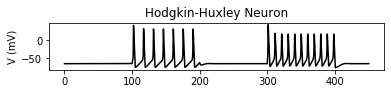

In [3]:
X = odeint(compute_derivs, [-65, 0.05, 0.6, 0.32], t)
V = X[:,0]
m = X[:,1]
h = X[:,2]
n = X[:,3]
ina = I_Na(V, m, h)
ik = I_K(V, n)
il = I_L(V)

plt.figure()

plt.subplot(4,1,1)
plt.title('Hodgkin-Huxley Neuron')
plt.plot(t, V, 'k')
plt.ylabel('V (mV)')